In [1]:
from astropy.io import fits
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

Moves all the science files and then the cosmic ray masks, then finally the ignore masks.

In [10]:
science_files = glob.glob(os.path.join(os.curdir, "*", "*_flt.fits"))
save_loc = "./data/images/"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, save_loc + root)

0


In [ ]:
science_files = glob.glob(os.path.join(os.curdir,"*", "*sci1_crmask.fits"))
save_loc = "./data/masks/"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, save_loc + root)

In [101]:
science_files = glob.glob(os.path.join(os.curdir, "Drizzle Notebooks", "*", "*sci1_single_mask.fits"))
save_loc = "./data/ignore/"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
for im in science_files:
    root = im.split('/')[-1]
    shutil.copyfile(im, save_loc + root)

Plotting a section of one of the images just to test.

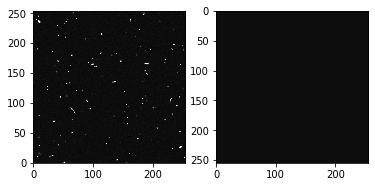

In [2]:
sci = fits.getdata(os.path.join(os.curdir, "data", "images", "jbit11dsq_flt.fits"))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sci[0:255, 0:255], vmin = 0, vmax = 1000, cmap="gray", origin='lower')
ax[1].imshow(np.full_like(sci[0:255, 0:255], np.median(sci)),vmin = 0, vmax = 1000, cmap="gray")

Creates a concatenated stack of all the 256x256 square images.

In [3]:
def get_images(image_names):
    big = []
    big_mask = []
    big_ignore = []
    
    # Loop over the list of image names and extract all the full names
    for n in image_names:
        image_files = glob.glob(os.path.join(os.curdir, "data", "images", n + "*_flt.fits"))
        for name in image_files:
            
            name = name.split("/")[-1].split("flt")[0]
            
            # Loads the image, then loads the corresponding CR mask.
            working = fits.getdata(os.path.join(os.curdir, "data", "images", name + "flt.fits"))
            working_mask = fits.getdata(os.path.join(os.curdir, "data", "masks", name + "sci1_crmask.fits"))
            working_ignore = fits.getdata(os.path.join(os.curdir, "data", "ignore", name + "sci1_single_mask.fits")) == 0
            
            # Loops over the image and slices it up into 256x256 squares.
            for i in range(128, working.shape[0] - 128, 256):
                for j in range(128, working.shape[1] - 128, 256):
                    big.append(working[i:i+256, j:j+256].reshape(1, 256, 256))
                    big_mask.append(working_mask[i:i+256, j:j+256].reshape(1, 256, 256))
                    
                    temp_ignore = working_ignore[i:i+256, j:j+256].reshape(1, 256, 256)
                    big_ignore.append(temp_ignore)
                    
            for i in range(256, working.shape[0] - 255, 256):
                for j in range(256, working.shape[1] - 255, 256):
                    big.append(working[i:i+256, j:j+256].reshape(1, 256, 256))
                    big_mask.append(working_mask[i:i+256, j:j+256].reshape(1, 256, 256))
                    
                    temp_ignore = working_ignore[i:i+256, j:j+256].reshape(1, 256, 256)
                    big_ignore.append(temp_ignore)
            #print(len(big))
            
    # Concatenates the images into nice numpy arrays
    big = np.concatenate(big)
    big_mask = np.concatenate(big_mask)
    big_ignore = np.concatenate(big_ignore)
    
    return (big, big_mask, big_ignore)

In [4]:
test_size = 0.29 # So I can change all of them at once.

# Extragalactic field
eg_field_names = ["j9700", "jbit1", "jcoz44"]
eg_data, eg_masks, eg_ignore = get_images(eg_field_names)

# Arrays of 3 in order: image, mask, ignore
eg_test = [0,0,0]
eg_train = [0,0,0]
eg_train[0], eg_test[0], eg_train[1], eg_test[1], eg_train[2], eg_test[2] = train_test_split(eg_data, 
                                                                                             eg_masks, 
                                                                                             eg_ignore, 
                                                                                             test_size=test_size)

# Globular cluster
gc_names = ["j9l90"] # Conveniently in the dataset these are from the same location
gc_data, gc_masks, gc_ignore = get_images(gc_names)

gc_test = [0,0,0]
gc_train = [0,0,0]
gc_train[0], gc_test[0], gc_train[1], gc_test[1], gc_train[2], gc_test[2] = train_test_split(gc_data, 
                                                                                             gc_masks, 
                                                                                             gc_ignore, 
                                                                                             test_size=test_size)

# Resolved galaxy
res_names = ["j8z00", "j9el3", "j90o"]
res_data, res_masks, res_ignore = get_images(res_names)

res_test = [0,0,0]
res_train = [0,0,0]
res_train[0], res_test[0], res_train[1], res_test[1], res_train[2], res_test[2] = train_test_split(res_data,
                                                                                                   res_masks, 
                                                                                                   res_ignore,
                                                                                                   test_size=test_size)
# Joins all the training data 
im_train = np.concatenate([eg_train[0], gc_train[0], res_train[0]])
mask_train = np.concatenate([eg_train[1], gc_train[1], res_train[1]])
ignore_train = np.concatenate([eg_train[2], gc_train[2], res_train[2]])

# Sky background levels the quick and dirty way.
sky_train = np.asarray([np.median(i) for i in im_train])

print(im_train.shape)
print(mask_train.shape)
print(ignore_train.shape)
print(sky_train.shape)


(8646, 256, 256)
(8646, 256, 256)
(8646, 256, 256)
(8646,)


In [5]:
from deepCR import deepCR
from deepCR import train
from deepCR import roc

Begin first 80 epochs of training
Use batch activate statistics for batch normalization; keep running mean to be used after these epochs

----------- epoch = 1 -----------
[TPR=0.995, FPR=0.336] @threshold = 0.5
loss = 0.0260

----------- epoch = 2 -----------
[TPR=0.998, FPR=0.340] @threshold = 0.5
loss = 0.0180

----------- epoch = 3 -----------
[TPR=0.998, FPR=0.368] @threshold = 0.5
loss = 0.0177

----------- epoch = 4 -----------
[TPR=0.999, FPR=0.360] @threshold = 0.5
loss = 0.0176

----------- epoch = 5 -----------
[TPR=0.998, FPR=0.339] @threshold = 0.5
loss = 0.0182

----------- epoch = 6 -----------
[TPR=0.998, FPR=0.302] @threshold = 0.5
loss = 0.0181

----------- epoch = 7 -----------
[TPR=0.998, FPR=0.285] @threshold = 0.5
loss = 0.0158

----------- epoch = 8 -----------
[TPR=0.997, FPR=0.301] @threshold = 0.5
loss = 0.0181

----------- epoch = 9 -----------
[TPR=0.998, FPR=0.319] @threshold = 0.5
loss = 0.0151



/home/dylang/.conda/envs/manta/lib/python3.7/site-packages/deepCR/training.py:212: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(self.img0[0, 0].detach().cpu().numpy()), cmap='gray')


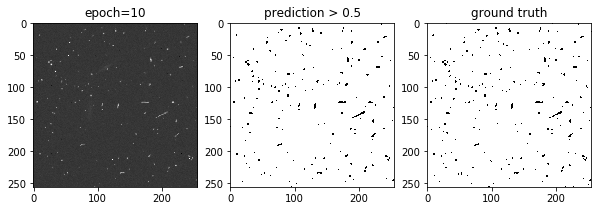

----------- epoch = 10 -----------
[TPR=0.998, FPR=0.282] @threshold = 0.5
loss = 0.0164

----------- epoch = 11 -----------
[TPR=0.999, FPR=0.304] @threshold = 0.5
loss = 0.0148

----------- epoch = 12 -----------
[TPR=0.999, FPR=0.311] @threshold = 0.5
loss = 0.0142

----------- epoch = 13 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0136

----------- epoch = 14 -----------
[TPR=0.999, FPR=0.299] @threshold = 0.5
loss = 0.0136

----------- epoch = 15 -----------
[TPR=0.998, FPR=0.281] @threshold = 0.5
loss = 0.0173

----------- epoch = 16 -----------
[TPR=0.999, FPR=0.338] @threshold = 0.5
loss = 0.0159

----------- epoch = 17 -----------
[TPR=0.998, FPR=0.279] @threshold = 0.5
loss = 0.0163



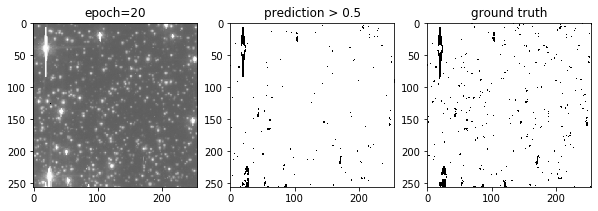

----------- epoch = 20 -----------
[TPR=0.999, FPR=0.327] @threshold = 0.5
loss = 0.0139

----------- epoch = 21 -----------
[TPR=0.999, FPR=0.322] @threshold = 0.5
loss = 0.0139

----------- epoch = 22 -----------
[TPR=0.999, FPR=0.329] @threshold = 0.5
loss = 0.0139

----------- epoch = 23 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0137

----------- epoch = 24 -----------
[TPR=0.999, FPR=0.324] @threshold = 0.5
loss = 0.0135
Saved to 2019-11-01_low+2_epoch24.pth

----------- epoch = 25 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0141

----------- epoch = 26 -----------
[TPR=0.999, FPR=0.312] @threshold = 0.5
loss = 0.0141

----------- epoch = 27 -----------
[TPR=0.999, FPR=0.328] @threshold = 0.5
loss = 0.0132
Saved to 2019-11-01_low+2_epoch27.pth

----------- epoch = 28 -----------
[TPR=0.999, FPR=0.325] @threshold = 0.5
loss = 0.0136

----------- epoch = 29 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0130
Saved to 2019-11-01_low+2

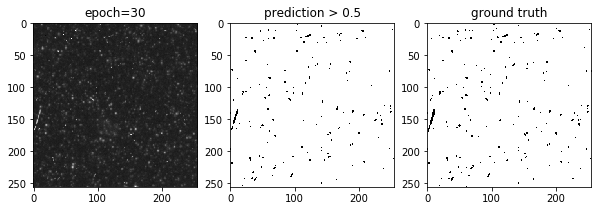

----------- epoch = 30 -----------
[TPR=0.999, FPR=0.316] @threshold = 0.5
loss = 0.0136

----------- epoch = 31 -----------
[TPR=0.999, FPR=0.312] @threshold = 0.5
loss = 0.0137

----------- epoch = 32 -----------
[TPR=0.999, FPR=0.316] @threshold = 0.5
loss = 0.0135

----------- epoch = 33 -----------
[TPR=0.999, FPR=0.312] @threshold = 0.5
loss = 0.0134

----------- epoch = 34 -----------
[TPR=0.999, FPR=0.327] @threshold = 0.5
loss = 0.0140
Epoch    33: reducing learning rate of group 0 to 5.0000e-05.

----------- epoch = 35 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0137

----------- epoch = 36 -----------
[TPR=0.999, FPR=0.314] @threshold = 0.5
loss = 0.0137

----------- epoch = 37 -----------
[TPR=0.999, FPR=0.314] @threshold = 0.5
loss = 0.0136

----------- epoch = 38 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0135

----------- epoch = 39 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0135



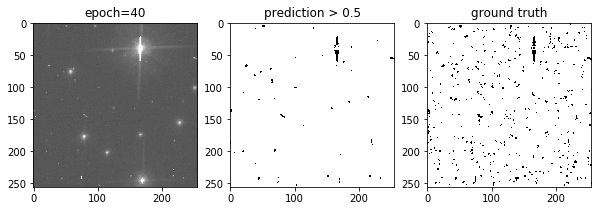

----------- epoch = 40 -----------
[TPR=0.999, FPR=0.313] @threshold = 0.5
loss = 0.0136

----------- epoch = 41 -----------
[TPR=0.999, FPR=0.314] @threshold = 0.5
loss = 0.0135
Epoch    40: reducing learning rate of group 0 to 5.0000e-06.

----------- epoch = 42 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 43 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 44 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 45 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0136

----------- epoch = 46 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0136

----------- epoch = 47 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 48 -----------
[TPR=0.999, FPR=0.316] @threshold = 0.5
loss = 0.0135
Epoch    47: reducing learning rate of group 0 to 5.0000e-07.

----------- epoch = 49 -----------
[TPR=0.999, FPR=0.315] @thresho

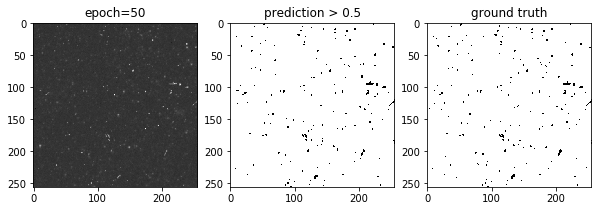

----------- epoch = 50 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 51 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 52 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 53 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 54 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 55 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135
Epoch    54: reducing learning rate of group 0 to 5.0000e-08.

----------- epoch = 56 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 57 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 58 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 59 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135



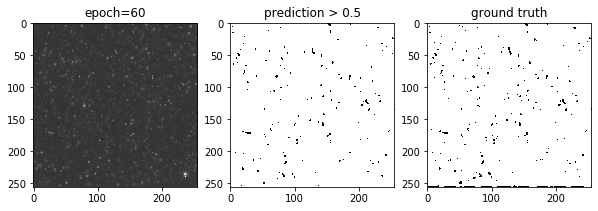

----------- epoch = 60 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 61 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 62 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135
Epoch    61: reducing learning rate of group 0 to 5.0000e-09.

----------- epoch = 63 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 64 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 65 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 66 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 67 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 68 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 69 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135



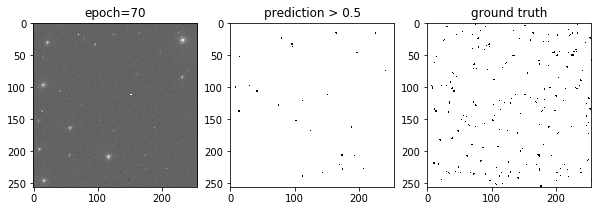

----------- epoch = 70 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 71 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 72 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 73 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 74 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 75 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 76 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 77 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 78 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

----------- epoch = 79 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135



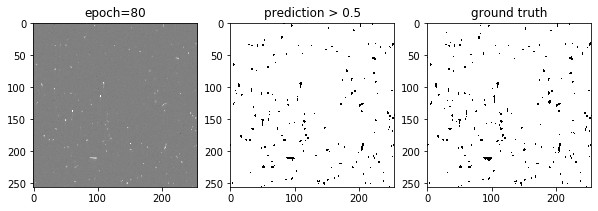

----------- epoch = 80 -----------
[TPR=0.999, FPR=0.315] @threshold = 0.5
loss = 0.0135

Continue onto next 120 epochs of training
Batch normalization running statistics frozen and used

----------- epoch = 81 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch81.pth

----------- epoch = 82 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch82.pth

----------- epoch = 83 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch83.pth

----------- epoch = 84 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch84.pth

----------- epoch = 85 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch85.pth

----------- epoch = 86 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch86.pth

----------- epoch = 87 -----------
[TPR=0.99

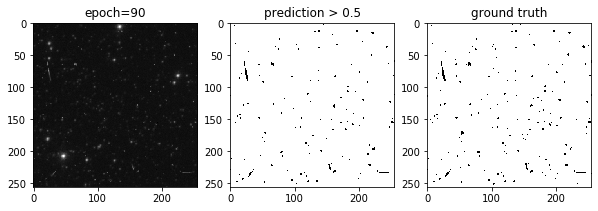

----------- epoch = 90 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch90.pth

----------- epoch = 91 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch91.pth

----------- epoch = 92 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch92.pth

----------- epoch = 93 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch93.pth

----------- epoch = 94 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch94.pth

----------- epoch = 95 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch95.pth

----------- epoch = 96 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch96.pth

----------- epoch = 97 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-1

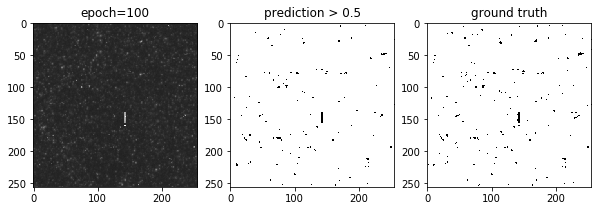

----------- epoch = 100 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch100.pth

----------- epoch = 101 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch101.pth

----------- epoch = 102 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch102.pth

----------- epoch = 103 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch103.pth

----------- epoch = 104 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch104.pth

----------- epoch = 105 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch105.pth

----------- epoch = 106 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch106.pth

----------- epoch = 107 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129


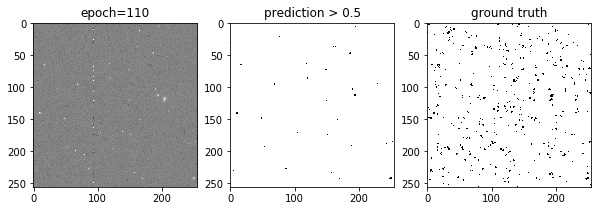

----------- epoch = 110 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch110.pth

----------- epoch = 111 -----------
[TPR=0.999, FPR=0.320] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch111.pth

----------- epoch = 112 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch112.pth

----------- epoch = 113 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch113.pth

----------- epoch = 114 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch114.pth

----------- epoch = 115 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch115.pth

----------- epoch = 116 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch116.pth

----------- epoch = 117 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129


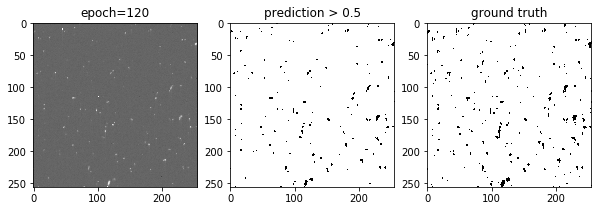

----------- epoch = 120 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch120.pth

----------- epoch = 121 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch121.pth

----------- epoch = 122 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch122.pth

----------- epoch = 123 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch123.pth

----------- epoch = 124 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch124.pth

----------- epoch = 125 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch125.pth

----------- epoch = 126 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129
Saved to 2019-11-01_low+2_epoch126.pth

----------- epoch = 127 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0129


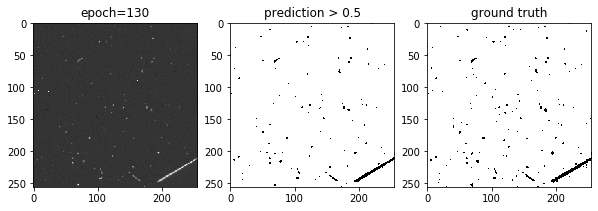

----------- epoch = 130 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch130.pth

----------- epoch = 131 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch131.pth

----------- epoch = 132 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch132.pth

----------- epoch = 133 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch133.pth

----------- epoch = 134 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch134.pth

----------- epoch = 135 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch135.pth

----------- epoch = 136 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch136.pth

----------- epoch = 137 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128


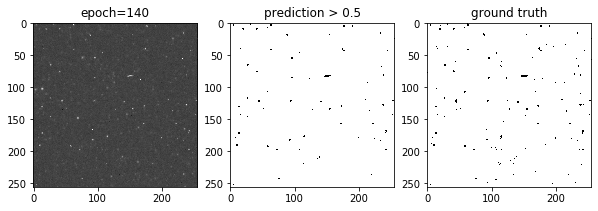

----------- epoch = 140 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch140.pth

----------- epoch = 141 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch141.pth

----------- epoch = 142 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch142.pth

----------- epoch = 143 -----------
[TPR=0.999, FPR=0.319] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch143.pth

----------- epoch = 144 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch144.pth

----------- epoch = 145 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch145.pth

----------- epoch = 146 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch146.pth

----------- epoch = 147 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128


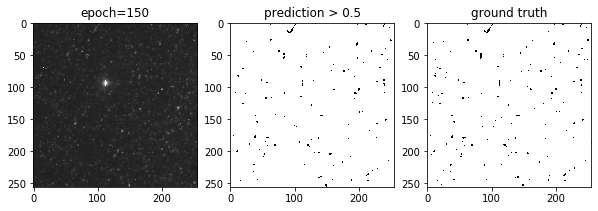

----------- epoch = 150 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch150.pth

----------- epoch = 151 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch151.pth

----------- epoch = 152 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch152.pth

----------- epoch = 153 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch153.pth

----------- epoch = 154 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch154.pth

----------- epoch = 155 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch155.pth

----------- epoch = 156 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch156.pth

----------- epoch = 157 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128


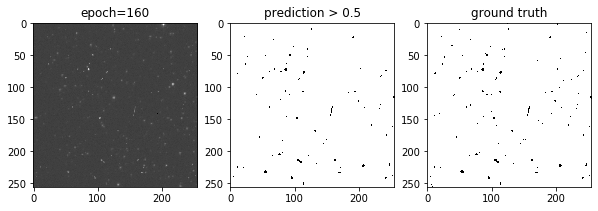

----------- epoch = 160 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch160.pth

----------- epoch = 161 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch161.pth

----------- epoch = 162 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch162.pth

----------- epoch = 163 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch163.pth

----------- epoch = 164 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch164.pth

----------- epoch = 165 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch165.pth

----------- epoch = 166 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch166.pth

----------- epoch = 167 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128


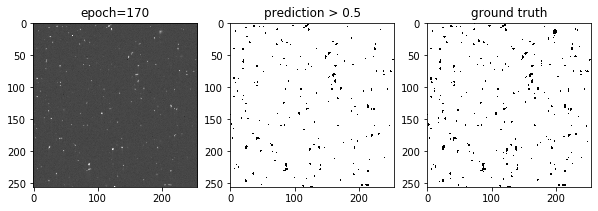

----------- epoch = 170 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch170.pth

----------- epoch = 171 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch171.pth

----------- epoch = 172 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch172.pth

----------- epoch = 173 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch173.pth

----------- epoch = 174 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch174.pth

----------- epoch = 175 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch175.pth

----------- epoch = 176 -----------
[TPR=0.999, FPR=0.318] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch176.pth

----------- epoch = 177 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128


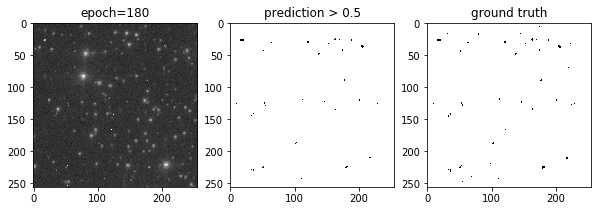

----------- epoch = 180 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch180.pth

----------- epoch = 181 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch181.pth

----------- epoch = 182 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch182.pth

----------- epoch = 183 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch183.pth

----------- epoch = 184 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch184.pth

----------- epoch = 185 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch185.pth

----------- epoch = 186 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch186.pth

----------- epoch = 187 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128


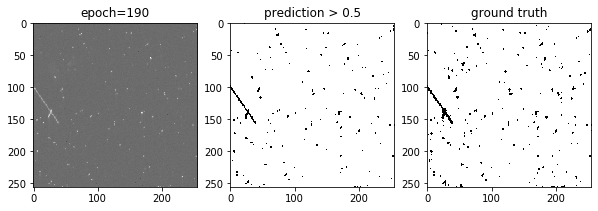

----------- epoch = 190 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0128
Saved to 2019-11-01_low+2_epoch190.pth

----------- epoch = 191 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch191.pth

----------- epoch = 192 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch192.pth

----------- epoch = 193 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch193.pth

----------- epoch = 194 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch194.pth

----------- epoch = 195 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch195.pth

----------- epoch = 196 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch196.pth

----------- epoch = 197 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127


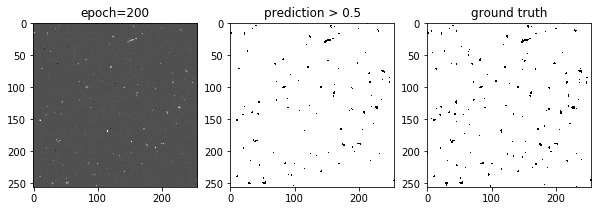

----------- epoch = 200 -----------
[TPR=0.999, FPR=0.317] @threshold = 0.5
loss = 0.0127
Saved to 2019-11-01_low+2_epoch200.pth



In [9]:
trainer = train(im_train, mask_train, ignore=ignore_train, name="low+2", sky=sky_train, aug_sky=[-0.9, 3],
                epoch=200, save_after=20, plot_every=10, use_tqdm=False, gpu=True)
trainer.train()
filename = trainer.save()

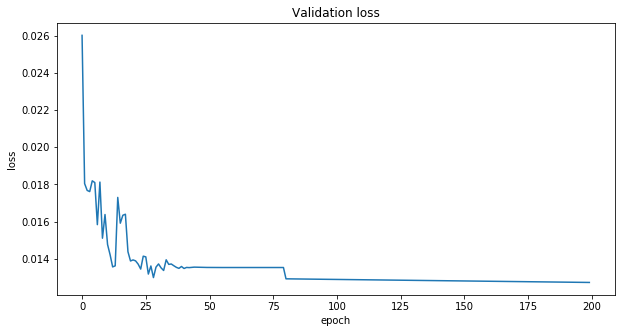

In [10]:
trainer.plot_loss()
#filename = trainer.save()

In [19]:
mdl = deepCR(mask='2019-11-01_low+2_epoch200.pth', hidden=32)

eg_tpr, eg_fpr = roc(mdl, image=eg_test[0], mask=eg_test[1], ignore=eg_test[2])
gc_tpr, gc_fpr = roc(mdl, image=gc_test[0], mask=gc_test[1], ignore=gc_test[2])
res_tpr, res_fpr = roc(mdl, image=res_test[0], mask=res_test[1], ignore=res_test[2])

100%|██████████| 1158/1158 [09:42<00:00,  1.99it/s]


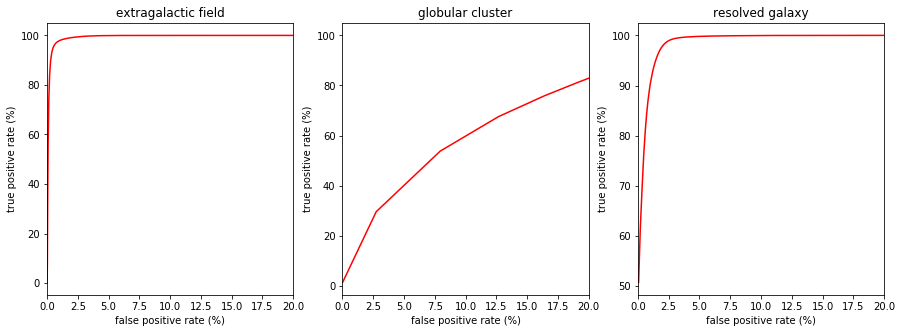

In [20]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

# Extragalactic field
x_max = 20
ax[0].plot(eg_fpr, eg_tpr, c="r")
ax[0].set_xlim(0, x_max)
ax[0].set_title("extragalactic field")
ax[0].set_xlabel("false positive rate (%)")
ax[0].set_ylabel("true positive rate (%)")

# Globular cluster
ax[1].plot(gc_fpr, gc_tpr, c="r")
ax[1].set_xlim(0, x_max)
ax[1].set_title("globular cluster")
ax[1].set_xlabel("false positive rate (%)")
ax[1].set_ylabel("true positive rate (%)")

# Resolved galaxy
ax[2].plot(res_fpr, res_tpr, c="r")
ax[2].set_xlim(0, x_max)
ax[2].set_title("resolved galaxy")
ax[2].set_xlabel("false positive rate (%)")
ax[2].set_ylabel("true positive rate (%)")

plt.show()

In [ ]:
# Test all of the data at once.
im_test = np.concatenate([eg_test[0], gc_test[0], res_test[0]])
mask_test = np.concatenate([eg_test[1], gc_test[1], res_test[1]])
ignore_test = np.concatenate([eg_test[2], gc_test[2], res_test[2]])
tpr, fpr = roc(mdl, image=im_test, mask=mask_test, ignore=ignore_test)

Text(0, 0.5, 'true positive rate (%)')

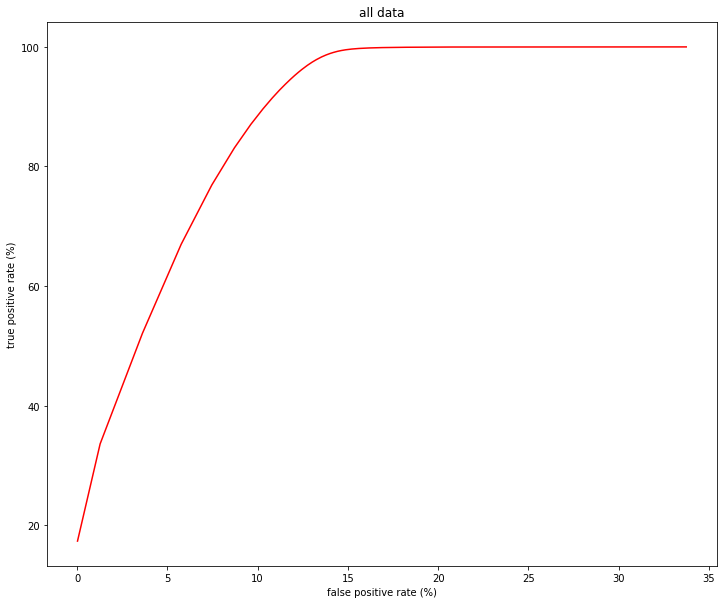

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)

ax.plot(fpr, tpr, c="r")
ax.set_xlim(0,100)
ax.set_title("all data")
ax.set_xlabel("false positive rate (%)")
ax.set_ylabel("true positive rate (%)")

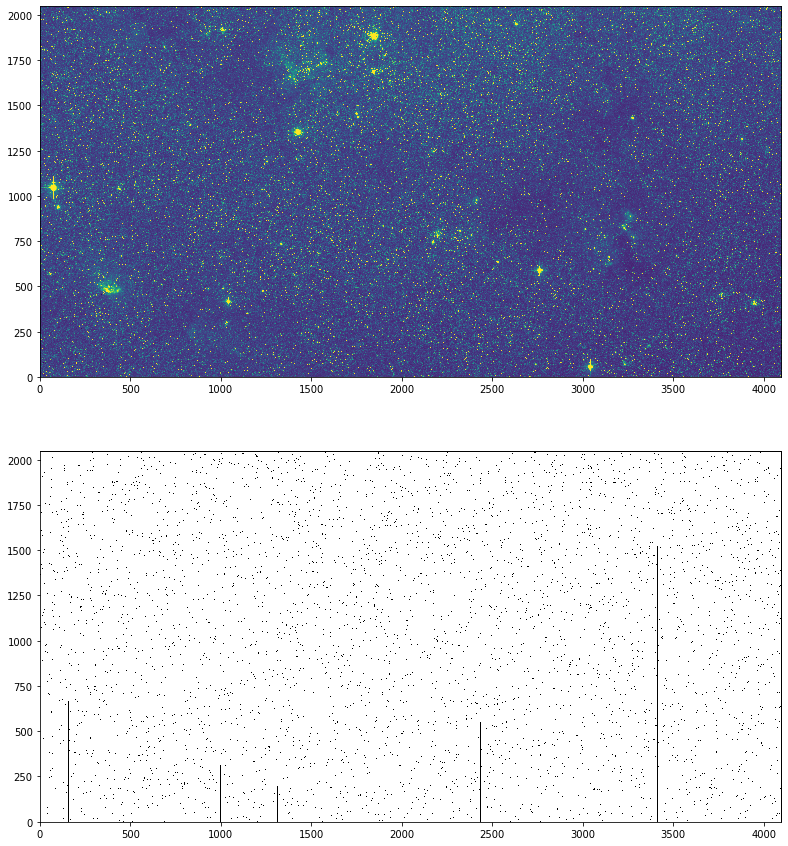

In [21]:
sci1 = fits.getdata(os.path.join(os.curdir, "data", "images", "j90o28fjq_flt.fits"))
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 15)
ax[0].imshow(sci1, vmin=0, vmax=1000, cmap="viridis", origin='lower')

sci2 = fits.getdata(os.path.join(os.curdir, "Drizzle Notebooks", "HST-10190-28", "j90o28fjq_sci2_single_mask.fits"))
ax[1].imshow(sci2, cmap="gray", origin='lower')
